# Preparation de la base de travail

In [1]:
import urllib
import bs4 
import pandas as pd

**code de scrapping de dictionnaire de variables**

In [2]:
def scrapCeremaTable(url):
    url_cerema = url
    from urllib import request
    request_text = request.urlopen(url_cerema).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    table_cerema = page.find('table')
    rows = table_cerema.find_all('tr')
    dico_cerema = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        if len(cols) > 0 : 
            dico_cerema[cols[0]] = cols[1:]
    df = pd.DataFrame.from_dict(dico_cerema,orient='index')
    return(df)


In [3]:
df_mutation = scrapCeremaTable("http://doc-datafoncier.cerema.fr/dv3f/doc/table/mutation")
df_disp_parcelle = scrapCeremaTable("http://doc-datafoncier.cerema.fr/dv3f/doc/table/disposition_parcelle")
df_local = scrapCeremaTable("http://doc-datafoncier.cerema.fr/dv3f/doc/table/local")

In [4]:
df_mutation.head(5)

,0,1,2
1,idmutation,identifiant de clef primaire de la table mutation,Entier auto-incrémenté
2,idmutinvar,identifiant invariant de la mutation,Caractère(60)
3,idopendata,identifiant de mutation,Caractère(60)
4,idnatmut,identifiant de clef primaire de la table ann_n...,Entier
5,codservch,code du service de conservation des hypothèques,Caractère(7)


**Code d'extration d'une sous base utile (tri des colonnes inutiles notamment)**

In [5]:
import geopandas as gpd
import pandas as pd
import os
import dict_var

In [8]:
# import des dictionnaires de variables
df = pd.read_csv(r"C:\Users\joris\Google Drive\ENSAE\2A\S1\PythonDataScientist\Projet\DVF+ downloaded\DVF+r84\r84\r84_mutation.csv")
var_mutation = dict_var.scrapCeremaTable("http://doc-datafoncier.cerema.fr/dv3f/doc/table/mutation")
var_disp_parcelle = dict_var.scrapCeremaTable("http://doc-datafoncier.cerema.fr/dv3f/doc/table/disposition_parcelle")
var_local = dict_var.scrapCeremaTable("http://doc-datafoncier.cerema.fr/dv3f/doc/table/local")
var_main = pd.concat([var_mutation,var_disp_parcelle,var_local])

# nettoyage
cleaning_list = list(var_main[var_main[0].isin(df.columns)].reset_index().iloc[[4,5,11,12,61,62,63,64,65,66,68,69,70,71],1])
cleaning_list.remove('idmutation')
cleaning_list.remove('idmutation')
cleaning_list

columns = list(df.columns)
def private(l1,l2):
    liste = l1
    for e in l2:
        while e in liste:
            liste.remove(e)
    return(liste)
            
clean = private(columns,cleaning_list)
df[clean].to_csv("dataset_travail_exemple")

# Prix des maisons et géolocalisation dans la région Rhône-Alpes

**visualisation et k-means**

In [9]:
import pandas as pd
import dict_var
import geopandas as gpd
import pathlib
import geopandas as gpd
import fiona
from shapely.geometry import shape
import numpy as np

In [3]:
# utilisation de la base précédente
df = pd.read_csv("dataset_travail") 

**sélection des variables utiles**

In [4]:
df_kmeans = df[df["codtypbien"]==111][["idmutation","valeurfonc"]].copy()

    import du fichier shapefile contenant les localisations des bien

In [5]:
mut_loc = gpd.read_file("C:/Users/joris/Google Drive/ENSAE/2A/S1/PythonDataScientist/Projet/DVF+ downloaded/DVF+r84/r84/r84_mutation_geomlocmut.shp")

**Jointure avec la base initiale**

In [6]:
joined = mut_loc.rename(columns={"IDMUTATION":"idmutation"}).copy().set_index("idmutation").join(df_kmeans.set_index('idmutation'))

In [7]:
joined = joined.dropna().copy()
joined.head(5)

,geometry,valeurfonc
idmutation,,
182211,POINT (836230.065 6544261.364),340330.00
182212,POINT (927971.196 6571548.719),383277.59
2219,POINT (851364.030 6537733.186),275000.00
76221,POINT (840852.047 6545144.615),226000.00
82151,POINT (869338.153 6572913.665),229000.00


**Creation de la matrice du K-means**

In [8]:
def getX(joined):
    A = joined["geometry"].tolist()
    B = joined["valeurfonc"].tolist()
    A = [[a.x,a.y] for a in A]
    A = [A[i]+[B[i]] for i in range(len(A))]
    return(A)

In [9]:
X = getX(joined)

import des librairies pour le kmeans

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

**Détermination du nombre de cluster optimal avec la méthode du coude**

In [11]:
def kmeans(X):
    max_k = 10
    
## iterations
    distortions = [] 
    for i in range(1, max_k+1):
        if len(X) >= i:
           model = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
           model.fit(X)
           distortions.append(model.inertia_)
## best k: the lowest derivative
    k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
    fig, ax = plt.subplots()
    ax.plot(range(1, len(distortions)+1), distortions)
    ax.axvline(k, ls='--', color="red", label="k = "+str(k))
    ax.set(title='The Elbow Method', xlabel='Number of clusters', 
           ylabel="Distortion")
    ax.legend()
    ax.grid(True)
    plt.show()
    return()

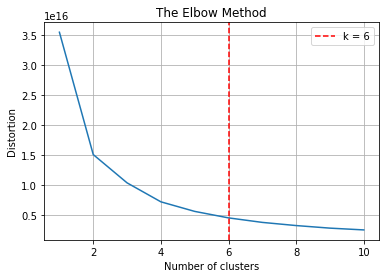

()

In [12]:
kmeans(X)

**Obtention des premiers clusters et tracé**

In [13]:
Clusters = pd.Series(KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(X))

In [14]:
Clusters.index=joined.index

In [15]:
Clustered =pd.concat([joined,Clusters],axis=1)

On observe des clusters très peu pertinents et lisibles, pour améliorer cela on essaie d'appliquer le kmeans sur la valeur foncière au mètre carré

<AxesSubplot:>

<Figure size 1440x1440 with 0 Axes>

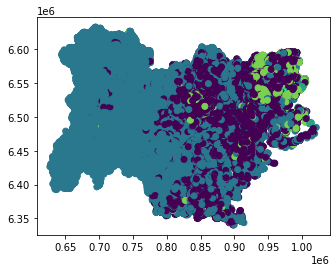

In [16]:
plt.figure(figsize=(20,20))
Clustered[["geometry",0]].plot(column=0)

**Pondération par la surface**

In [17]:
df_kmeans_sur = df[df["codtypbien"]==111].copy()
df_kmeans_sur["valeurfoncsur"]= df_kmeans_sur["valeurfonc"]/df_kmeans_sur["sbatmai"]

In [18]:
df_kmeans_sur["valeurfoncsur"]= df_kmeans_sur["valeurfonc"]/df_kmeans_sur["sbatmai"]


In [19]:
def getX_sur(joined):
    A = joined["geometry"].tolist()
    B = joined["valeurfoncsur"].tolist()
    A = [[a.x,a.y] for a in A]
    A = [A[i]+[B[i]] for i in range(len(A))]
    return(A)

In [20]:
df_kmeans_sur = df_kmeans_sur[["idmutation","valeurfoncsur"]].copy()
joined_sur = mut_loc.rename(columns={"IDMUTATION":"idmutation"}).copy().set_index("idmutation").join(df_kmeans_sur.set_index('idmutation'))
joined_sur = joined_sur.dropna().sort_values(by=["idmutation"]).copy()
X_sur = getX_sur(joined_sur)


**On fait tourner le kmeans sur la nouvelle matrice de coordonnées**

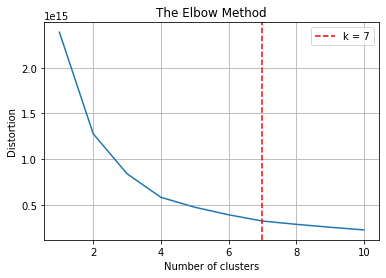

()

In [21]:
kmeans(X_sur)

In [22]:
Clusters_sur = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(X_sur)

**Tracé des clusters**

In [23]:
Cluster_series_sur = pd.Series(Clusters_sur)
Cluster_series_sur.index=joined_sur.index

In [24]:
Clustered_sur =pd.concat([joined_sur,Cluster_series_sur],axis=1)
Clustered_sur =Clustered_sur.rename(columns={0:"Cluster"})

**Les clusters sont intéressants mais quand on regarde la dispersion des prix on est peu satisfaits**

In [26]:
corresp_cluster = Clustered_sur.groupby("Cluster").mean('valeurfoncsur').sort_values(by='valeurfoncsur')
Clustered_sur["Cluster"] = Clustered_sur["Cluster"].apply(lambda x:corresp_cluster.loc[x])

<AxesSubplot:title={'center':'K-means sur la région Rhône-Alpes'}>

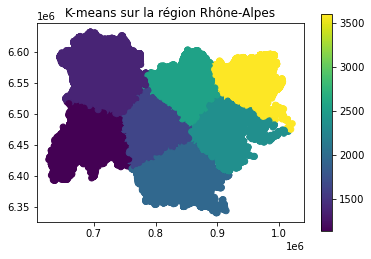

In [28]:
fig, ax = plt.subplots(1, 1)

plt.title("K-means sur la région Rhône-Alpes")
Clustered_sur[["geometry","Cluster"]].plot(column="Cluster",legend=True,ax=ax)

Les moyennes sont plutôt bonnes, on distingue de bonnes zones de prix

In [25]:
Clustered_sur.groupby("Cluster").mean('valeurfoncsur').sort_values(by='valeurfoncsur')


,valeurfoncsur
Cluster,
5,1136.955203
1,1386.185463
6,1641.360822
2,1960.904335
3,2357.127983
4,2553.410884
0,3600.875122


Malheureusement les ecarts types sont très dipersés

In [29]:
Clustered_sur.groupby("Cluster").std()

,valeurfoncsur
Cluster,
1136.955203,701.118406
1386.185463,772.986578
1641.360822,778.943389
1960.904335,8160.217309
2357.127983,2061.379367
2553.410884,1923.330488
3600.875122,2636.512260


# Raccord à la base commune

In [30]:
data_clustered = Clustered_sur.join(df.set_index('idmutation'))[["geometry","valeurfoncsur","Cluster","l_codinsee"]].copy()

In [31]:
def aggrege(s):
    string =""
    for i in s:
        if i!='{':
            string+=i
        if i=="," or i=="}":
            return(string[:-1])

In [33]:
data_clustered['l_codinsee']=data_clustered['l_codinsee'].apply(aggrege)

In [34]:
ra = gpd.read_file("communes-20190101.json")
ra = ra[ra["insee"].isin(list(data_clustered["l_codinsee"]))].copy()
ra = ra.rename(columns={"insee":"l_codinsee"}).set_index("l_codinsee")
carte = ra.join(data_clustered.groupby("l_codinsee")["Cluster"].mean()).copy()

In [75]:
def closest_cluster(x):
    c = Clustered_sur["Cluster"].unique()
    a = np.argmin([abs(c[i]-x) for i in range(len(c))])
    
    return(c[a])

In [79]:
carte["Cluster"] = carte["Cluster"].apply(closest_cluster)

<AxesSubplot:title={'center':'K-means sur la région Rhône-Alpes'}>

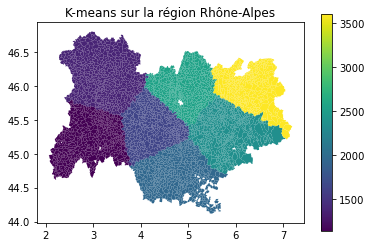

In [80]:
fig, ax = plt.subplots(1, 1)

plt.title("K-means sur la région Rhône-Alpes")
carte.plot(column="Cluster",legend=True,ax=ax)

**prix selon la localisation**

In [1]:
import pandas as pd
import dict_var
import geopandas as gpd
import pathlib
import geopandas as gpd
import fiona
from shapely.geometry import shape
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ra = gpd.read_file("communes-20190101.json")
mut_loc = gpd.read_file("C:/Users/joris/Google Drive/ENSAE/2A/S1/PythonDataScientist/Projet/DVF+ downloaded/DVF+r84/r84/r84_mutation_geomlocmut.shp")
df = pd.read_csv("dataset_travail")

In [3]:

df2 = df[df["codtypbien"]==111].copy()
df2["valeurfoncsur"]= df2["valeurfonc"]/df2["sbatmai"]
df2 = df2.set_index("idmutation")[["l_codinsee","valeurfoncsur"]]
df2 = mut_loc.rename(columns={"IDMUTATION":"idmutation"}).copy().set_index("idmutation").join(df2)
df2 = df2.dropna()

In [4]:
qmax = df2["valeurfoncsur"].quantile(q=0.99)
qmin = df2["valeurfoncsur"].quantile(q=0.01)

<AxesSubplot:title={'center':'Valeurfoncsur région Rhône-Alpes'}>

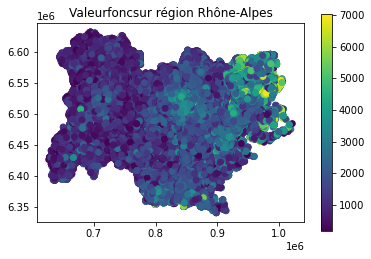

In [5]:
df3 = df2[df2["valeurfoncsur"].between(qmin,qmax)]
fig, ax = plt.subplots(1, 1)

plt.title("Valeurfoncsur région Rhône-Alpes")
df3[["geometry","valeurfoncsur"]].plot(column="valeurfoncsur",legend=True,ax=ax)

# Regression spatiale

In [4]:
def aggrege(s):
    string =""
    for i in s:
        if i!='{':
            string+=i
        if i=="," or i=="}":
            return(string[:-1])
df2['l_codinsee']=df2['l_codinsee'].apply(aggrege)


,valeurfoncsur
count,2.482390e+05
mean,2.171904e+03
std,3.327163e+03
min,0.000000e+00
25%,1.278846e+03
50%,1.918958e+03
75%,2.688172e+03
max,1.401961e+06


In [5]:
df2["l_codinsee"]= pd.to_numeric(df2["l_codinsee"])

In [6]:
def dummy(x,code):
    if x==code:
        return(1)
    else:
        return(0)

In [7]:
def preprocess(df2):
    df = df2.copy()
    for code in list(df2["l_codinsee"].unique()):
        df[code] = df["l_codinsee"].apply(lambda x: dummy(x,code))
    return(df.iloc[:,3:].to_numpy(),df['valeurfoncsur'].to_numpy())

In [8]:
X,y = preprocess(df2)

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [11]:
reg = LinearRegression().fit(X, y)

In [19]:
reg.coef_

array([-1.61598341e+12, -1.61598341e+12, -1.61598341e+12, ...,
       -1.61598341e+12, -1.61598341e+12, -1.61598341e+12])